In [62]:
#|****************************************************************|#
#|********** 04_Audio recognition (tensorflow v.2.x) *************|#
#|****************************************************************|# 
#|                                                                |#
#|     prerequisite : python v.3.x                                |#
#|                    tensorflow v.2.x                            |# 
#|                                                                |#
#|     shortcut to run a code : ctl + enter                       |#
#|                                                                |#
#|----------------------------------------------------------------|#

# ref : https://www.tensorflow.org/tutorials/audio/simple_audio?hl=en

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from IPython import display

In [64]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [65]:
#**********************
#\\\\\ Download data set + extract and load them
#**********************
# The original dataset consists of over 105,000 WAV audio files 
# of people saying thirty different words.
#**********************
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [66]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['right' 'go' '.DS_Store' 'no' 'left' 'stop' 'up' 'down' 'yes']


In [67]:
#**********************
#\\\\\ Extract audio file (.wav format)
#**********************
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/down/0ab3b47d_nohash_0.wav', shape=(), dtype=string)


total sample = 8000  ⇨ filenames
total label = 8      ⇨ commands

In [68]:
#**********************
#\\\\\ Split files into train, test, and validation sets 
#**********************
tot_size = filenames.shape[0]
train_size = np.int(tot_size*.8)
valid_size = np.int(tot_size*.1)
test_size = np.int(tot_size*.1)

train_files = filenames[0:train_size]
val_files = filenames[train_size:train_size+valid_size]
test_files = filenames[-test_size:]

In [69]:
#**********************
#\\\\\ Read audio files + label 
#**********************
### Define functions
#_______________________________________________
# 1) tf.audio.decode_wav
# : Decode a 16-bit PCM WAV file to a float tensor.
#_______________________________________________
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

#_______________________________________________
# 2) tf.strings.split
# : Split elements of input based on sep into a RaggedTensor.
#_______________________________________________
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [70]:
#_______________________________________________
# tf.data.experimental
# : Experimental API for building input pipelines
#_______________________________________________
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

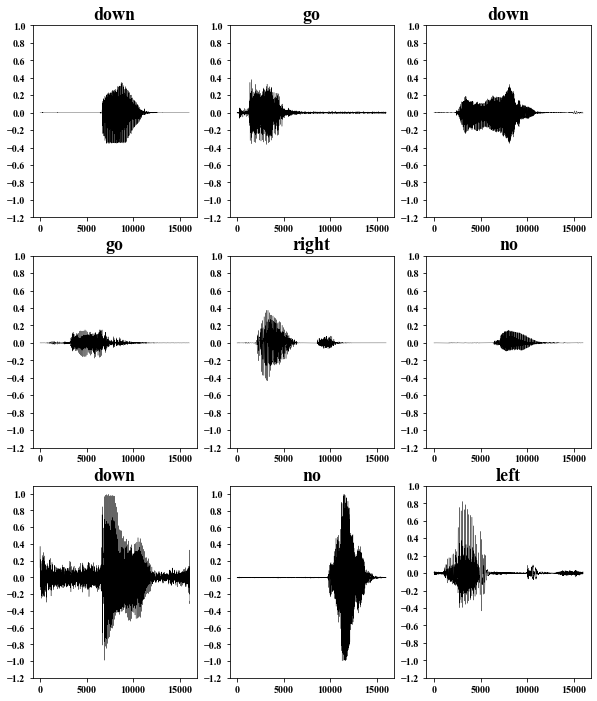

In [71]:
#**********************
#\\\\\ Visualize audio waveforms
#**********************
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
plt.rc('font',family='Times New Roman')
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  # plot waveform
  ax.plot(audio.numpy(),c='k',lw=.3)
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  # plot label
  label = label.numpy().decode('utf-8')
  ax.set_title(label,fontsize=18)

plt.show()

In [72]:
#**********************
#\\\\\ Define function of spectrogram
#**********************
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [73]:
timescale.shape[0]

16000

In [74]:
#**********************
#\\\\\ Information of a single audio sample
#**********************
for waveform, label in waveform_ds.take(321):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=audio.shape[0]))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


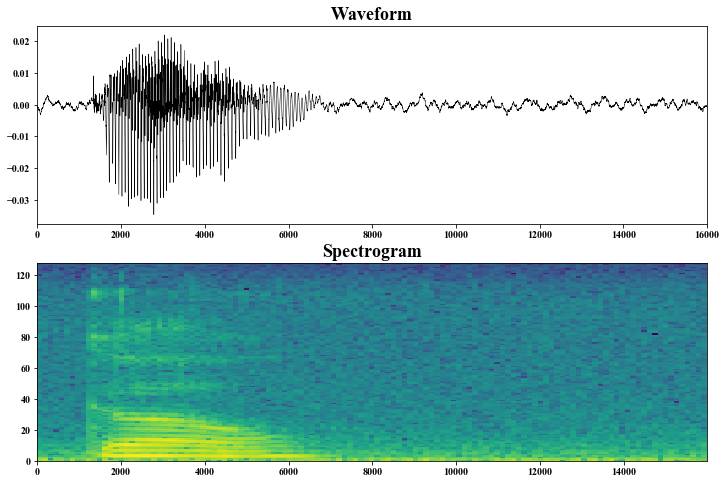

In [75]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy(),c='k',lw=.5)
axes[0].set_title('Waveform',fontsize=18)
axes[0].set_xlim([0, timescale.shape[0]])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram',fontsize=18)
plt.show()

...coming soon